1. Offline augmentation (przed treningiem)
   - zbalansowanie klas
   - augmentacja waveformów
   - augmentacja spektrogramów
   - wygenerowanie przykładów dla klasy silence
   - wygenerowanie spektrogramów

In [1]:
import random
import torchaudio
import os
import torchaudio.transforms as T
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import Audio

from AudioWaveformDataset import AudioWaveformDataset
from WaveformAugmentations import WaveformAugmentations
from SpectrogramAugmentations import SpectrogramAugmentations

SAMPLE_RATE = 16000
UNKNOWNS_COUNT = 2400 # average number of examples per class in the dataset (based on EDA.ipynb)

## Waveform Augmentation

In [2]:
def load_background_waveforms(background_noise_dir='data/train/audio/_background_noise_'):
    background_waveforms = []
    for file in os.listdir(background_noise_dir):
        if file.endswith('.wav'):
            try:
                path = os.path.join(background_noise_dir, file)
                waveform, sr = torchaudio.load(path)
                waveform = waveform.squeeze(0)  # remove channel dimension
                if sr != SAMPLE_RATE:
                    resampler = T.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)
                    waveform = resampler(waveform)
                background_waveforms.append(waveform)
                print(f"Loaded background: {file}")
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return background_waveforms

def waveform_augmentation_pipeline(sample_rate, background_waveforms=None, rir_waveforms=None, p=0.5):
    def augment_waveform(waveform):
        augmented = waveform
        if random.random() < p:
            augmented = WaveformAugmentations.time_shift(augmented)
        
        if random.random() < p:
            augmented = WaveformAugmentations.add_noise(augmented, noise_level=random.uniform(0.001, 0.005))
        
        if random.random() < p:
            augmented = WaveformAugmentations.pitch_shift(augmented, sample_rate)
        
        if random.random() < p:
            augmented = WaveformAugmentations.volume_control(augmented)
        
        if random.random() < p*0.6:
            augmented = WaveformAugmentations.speed_change(augmented, sample_rate)
            
        if random.random() < p*0.6:
            augmented = WaveformAugmentations.reverb(augmented, sample_rate)
        
        if background_waveforms and random.random() < p*0.8:
            bg_waveform = random.choice(background_waveforms)
            augmented = WaveformAugmentations.mix_background(augmented, bg_waveform)
        
        if rir_waveforms and random.random() < p*0.6:
            rir_waveform = random.choice(rir_waveforms)
            augmented = WaveformAugmentations.convolution_reverb(augmented, rir_waveform)
            
        return augmented
    return augment_waveform

def spectrogram_augmentation_pipeline(p=0.5):
    def augment_spectrogram(spectrogram):
        augmented = spectrogram
        if random.random() < p:
            time_mask_param = random.randint(5, 20)
            augmented = SpectrogramAugmentations.time_masking(augmented, time_mask_param)
        
        if random.random() < p:
            freq_mask_param = random.randint(5, 15)
            augmented = SpectrogramAugmentations.freq_masking(augmented, freq_mask_param)
        return augmented
    
    return augment_spectrogram

Test waveform augmentation pipeline

In [3]:
background_waveforms = load_background_waveforms()
augmentation_pipeline = waveform_augmentation_pipeline(sample_rate=SAMPLE_RATE, p=0.2)

wav_path = r"data\train\audio\yes\0c2ca723_nohash_0.wav"
waveform, sample_rate = torchaudio.load(wav_path)
waveform = waveform.squeeze(0)  # remove channel dimension
Audio(waveform.numpy(), rate=sample_rate)

Loaded background: doing_the_dishes.wav
Loaded background: dude_miaowing.wav
Loaded background: exercise_bike.wav
Loaded background: pink_noise.wav
Loaded background: running_tap.wav
Loaded background: white_noise.wav


In [4]:
augmented_waveform = augmentation_pipeline(waveform)
Audio(augmented_waveform.numpy(), rate=sample_rate)

Test spectrogram augmentation pipeline

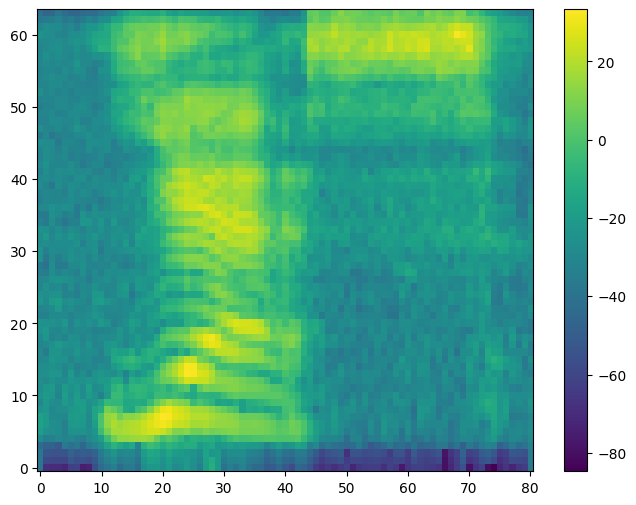

In [5]:
mel_spectrogram = T.MelSpectrogram(
    sample_rate=16000,
    n_mels=64,
)
db_transform = T.AmplitudeToDB()

spectrogram = mel_spectrogram(waveform)
spectrogram = db_transform(spectrogram)

plt.figure(figsize=(8, 6))
plt.imshow(spectrogram.squeeze().numpy(), origin="lower", aspect="auto", cmap="viridis")
plt.colorbar()
plt.show()

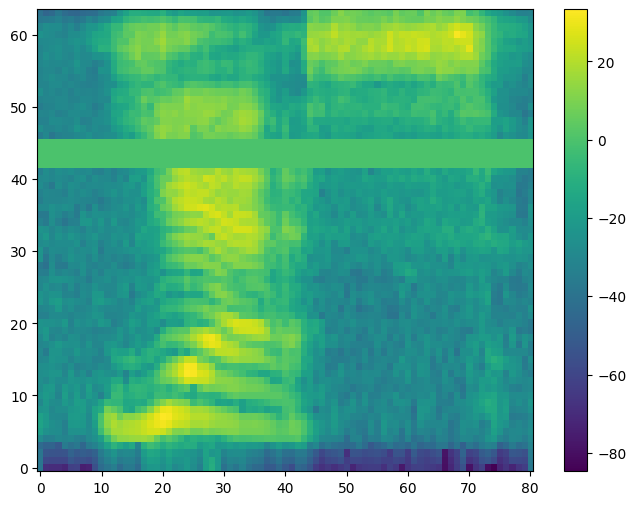

In [6]:
augmented_spectrogram = spectrogram_augmentation_pipeline(1.0)(spectrogram)
plt.figure(figsize=(8, 6))
plt.imshow(augmented_spectrogram.squeeze().numpy(), origin="lower", aspect="auto", cmap="viridis")
plt.colorbar()
plt.show()

## Run data preparation

In [7]:
def preprocess_with_augmentation(
    audio_dir, 
    output_dir,
    sample_rate=16000,
    n_mels=64,
    n_fft=400,
    hop_length=200,
    augment_probability=0.5,
    max_augmented_copies=1,  # Number of augmented copies to generate per original sample
):
    os.makedirs(output_dir, exist_ok=True)
    
    background_waveforms = load_background_waveforms()
    
    waveform_augment_fn = waveform_augmentation_pipeline(
        sample_rate, 
        background_waveforms, 
        p=augment_probability)
    spec_augment_fn = spectrogram_augmentation_pipeline(p=augment_probability / 2)
    
    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
    )
    db_transform = T.AmplitudeToDB()
        
    dataset = AudioWaveformDataset(audio_dir)
    print(f"Processing {len(dataset)} audio files...")
    
    l = list(zip(dataset.filepaths, dataset.labels))
    random.shuffle(l)
    unknowns_count = 0
    for audio_file, label_idx in tqdm(l, desc="Processing audio files"):
        label = dataset.idx2label[label_idx]
        if label == 'unknown' and unknowns_count >= UNKNOWNS_COUNT:
            continue
        elif label == 'unknown':
            unknowns_count += 1
        
        # Load audio
        waveform, orig_sr = torchaudio.load(audio_file)
        waveform = waveform.squeeze(0)  # remove channel dimension
        
        # Resample if necessary
        if orig_sr != sample_rate:
            resampler = T.Resample(orig_freq=orig_sr, new_freq=sample_rate)
            waveform = resampler(waveform)
        
        # Save original spectrogram
        spec = mel_spectrogram(waveform)
        spec = db_transform(spec)
        output_path = os.path.join(output_dir, os.path.splitext(audio_file)[0] + '.pt')
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        torch.save(spec, output_path)
        
        # Generate augmented versions
        augmented_copies = random.randint(0, max_augmented_copies)
        for i in range(augmented_copies):
            # Apply waveform augmentation
            augmented = waveform_augment_fn(waveform)
            
            # Generate spectrogram for augmented waveform
            spectrogram = mel_spectrogram(augmented)
            spectrogram = db_transform(spectrogram)
            augmented_spectrogram = spec_augment_fn(spectrogram)
            
            # Save augmented spectrogram with suffix
            aug_output_path = os.path.join(
                output_dir, 
                os.path.splitext(audio_file)[0] + f'_aug{i+1}.pt'
            )
            os.makedirs(os.path.dirname(aug_output_path), exist_ok=True)
            torch.save(augmented_spectrogram, aug_output_path)
    
    print(f"All spectrograms saved to {output_dir}")

In [8]:
class_counts = preprocess_with_augmentation(
    audio_dir="data/train/audio", 
    output_dir="data/train/spectrograms",
    augment_probability=0.1,  
    max_augmented_copies=1,
    sample_rate=SAMPLE_RATE,
)

Loaded background: doing_the_dishes.wav
Loaded background: dude_miaowing.wav
Loaded background: exercise_bike.wav
Loaded background: pink_noise.wav
Loaded background: running_tap.wav
Loaded background: white_noise.wav
Processing 64727 audio files...


Processing audio files:   3%|▎         | 1631/64727 [01:47<1:09:13, 15.19it/s]


KeyboardInterrupt: 